# Transfer Learning

We'll use a pretrained ResNet model to classify flowers.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms

In [2]:
# use gpu if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Using', device)

Using cuda


# Download and Organise Image Files

In [3]:
#downloaded from kaggle: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
import zipfile, os, glob
zipfile.ZipFile('data/flowers.zip').extractall('data')
DATA_DIR = 'data/flowers'
# get the file names
class_labels = os.listdir(DATA_DIR) 
print(class_labels)
image_files = glob.glob(os.path.join(DATA_DIR, "*/*")) # two directories deep, returns full paths
len(image_files)
image_labels = [f.split('/')[2] for f in image_files] # label for each image (parent folder)

['tulip', 'dandelion', 'daisy', 'sunflower', 'rose']


In [4]:
# train test split
from sklearn.model_selection import train_test_split

train_files, test_files, train_labels, test_labels = train_test_split(
    image_files, image_labels, test_size=0.1, stratify=image_labels)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.1, stratify=train_labels)

print(len(train_files), len(val_files), len(test_files))
print(len(train_labels), len(val_labels), len(test_labels))

3496 389 432
3496 389 432


In [5]:
# now we copy
import shutil
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')
test_dir = os.path.join(DATA_DIR, 'test')

def copy_files(source_files, dest_dir, labels):
    # takes the source files, and places them in a folder *dest_dir*
    # e.g. from data/flowers/class/file.jpg to data/flowers/*dest_dir*/class/file.jpg
    os.makedirs(dest_dir, exist_ok=True)
    for label in class_labels:
        os.makedirs(os.path.join(dest_dir, label), exist_ok=True)
    dest_paths = [os.path.join(dest_dir, f) for f in ['/'.join(f.split('/')[-2:]) for f in source_files]]
    for src, dst in zip(source_files, dest_paths):
        shutil.copy(src, dst)
copy_files(train_files, train_dir, class_labels)
print('train copied')
copy_files(val_files, val_dir, class_labels)
print('val copied')
copy_files(test_files, test_dir, class_labels)
print('test copied')

train copied
val copied
test copied


In [6]:
# clean up by removing the old directories we copied the files from
for label in class_labels:
    shutil.rmtree(os.path.join(DATA_DIR, label))

# Create Pytorch Image Datasets

In [7]:
# normalization used by pretrained model for the 3 RGB channels
# see: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize(256), #smaller image dim matched to this, scale maintained
    transforms.RandomResizedCrop(224), # this is the final output pixels: 224/224
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

test_transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224), # non random square crop for val/test, output pixels :224x224
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

image_datasets = {}
image_datasets['train'] = datasets.ImageFolder(train_dir, train_transform)
image_datasets['val'] = datasets.ImageFolder(val_dir, test_transform)
image_datasets['test'] = datasets.ImageFolder(test_dir, test_transform)
class_labels = image_datasets['train'].classes

#sanity checks:
for k, v in image_datasets.items():
    print(f'{k} files:', len(v))

train files: 3496
val files: 389
test files: 432


In [8]:
# now we build the dataloaders
dataloaders = {}
for k, dataset in image_datasets.items():
    is_train = True if k == 'train' else False
    dataloaders[k] = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=is_train, num_workers=4)

for k, v in dataloaders.items():
    print(f'{k} batches:', len(v))

train batches: 437
val batches: 49
test batches: 54


In [9]:
# view dimensions of an example batch
images, labels = next(iter(dataloaders['train']))
images.shape, labels.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


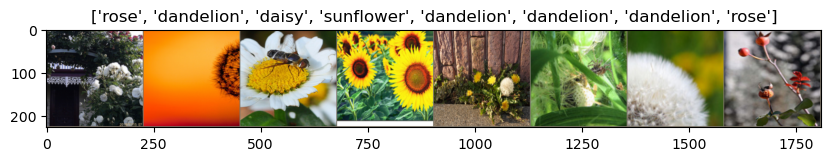

In [10]:
#view example batch
image_grid = torchvision.utils.make_grid(images)
image_grid = np.transpose(image_grid, [1,2,0])
image_grid = image_grid * np.array(std) + np.array(mean)
plot_title = np.array(class_labels)[labels.numpy()].tolist()
plt.figure(figsize=(10,5))
plt.imshow(image_grid)
plt.title(plot_title)
plt.show()

# Download Model and Train

In [11]:
model = models.resnet18(pretrained=True)
#freeze layers
for param in model.parameters():
    param.requires_grad = False

/home/sos00/miniforge3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sos00/miniforge3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/sos00/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [12]:
num_features = model.fc.in_features
print(num_features)

512


In [17]:
num_epochs = 10
lr = 0.01

model.fc = nn.Linear(num_features, len(class_labels)) # replace the final layer (5 output classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# reduce learning rate by 0.1 every 7 epocsh
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 

In [18]:

def train_step(dataloader):
  model.train()
  epoch_loss, num_correct, num_samples = 0, 0, 0
  for i, (images, labels) in enumerate(dataloader):
    lr_scheduler.step()
    
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    
    optimizer.zero_grad() # wipe gradients
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    #outputs for metrics
    _, predictions = torch.max(outputs,1) # returns val, index
    num_samples += len(labels)
    num_correct += (predictions == labels).sum().item()
    epoch_loss += loss.item()

  return epoch_loss/num_samples, num_correct/num_samples

def test_step(dataloader):
  model.eval()
  num_correct, num_samples = 0, 0
  for i, (images, labels) in enumerate(dataloader):
    with torch.no_grad():
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predictions = torch.max(outputs,1) # returns val, index
      num_samples += len(labels)
      num_correct += (predictions == labels).sum().item()

  return num_correct/num_samples

model.to(device)
for epoch in range(num_epochs):
  loss, train_acc = train_step(dataloaders['train'])
  val_acc = test_step(dataloaders['val'])
  
  print(f'epoch({epoch+1})',
        f'train_loss: {loss:.2f}, train_acc: {train_acc:.2f}, val_acc {val_acc:.2f}')

/home/sos00/miniforge3/envs/pytorch-env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


epoch(1) train_loss: 0.25, train_acc: 0.47, val_acc 0.50
epoch(2) train_loss: 0.25, train_acc: 0.47, val_acc 0.51
epoch(3) train_loss: 0.25, train_acc: 0.47, val_acc 0.49
epoch(4) train_loss: 0.25, train_acc: 0.47, val_acc 0.49
epoch(5) train_loss: 0.25, train_acc: 0.46, val_acc 0.51
epoch(6) train_loss: 0.24, train_acc: 0.47, val_acc 0.51
epoch(7) train_loss: 0.25, train_acc: 0.46, val_acc 0.50
epoch(8) train_loss: 0.25, train_acc: 0.47, val_acc 0.50
epoch(9) train_loss: 0.25, train_acc: 0.47, val_acc 0.50
epoch(10) train_loss: 0.25, train_acc: 0.47, val_acc 0.50


In [ ]:
# test data
test_acc = test_step(dataloaders['test'])
print(f'test accuracy: {test_acc:.2f}')